<a href="https://colab.research.google.com/github/bipinr8/MH_cash_deployment/blob/main/Morgan_Housel_Cash_deployment_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Morgan Housel's cash deployment strategy**.

How to deploy surplus cash, according to Morgan Housel
When the market crashes 10%, deploy
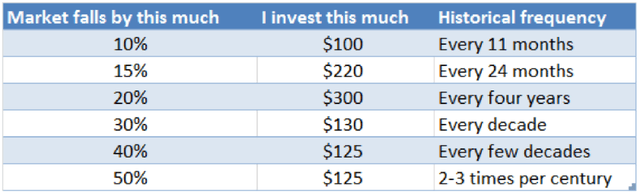

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#Importing libraries
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library

In [32]:
# reading excel file into data frame
df_source = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/MH/Source_data.xlsx',
                       sheet_name='Sheet1')

print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [33]:

# checking data frame
df_source.head()

,Date,Liquid NAV,Nifty 100
0,2003-01-01,1186.99,1000.00
1,2003-01-02,1187.16,1008.03
2,2003-01-03,1187.35,1004.49
3,2003-01-06,1187.92,999.85
4,2003-01-07,1188.09,997.81


In [34]:
# view df details
df_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5068 entries, 0 to 5067
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5068 non-null   datetime64[ns]
 1   Liquid NAV  5068 non-null   float64       
 2   Nifty 100   5068 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 118.9 KB


In [35]:
# import required libraries for graph plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
print ('Matplotlib version: ', mpl.__version__ )

# choosing plot style
print(plt.style.available)
mpl.style.use(['ggplot'])

Matplotlib version:  3.7.1
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


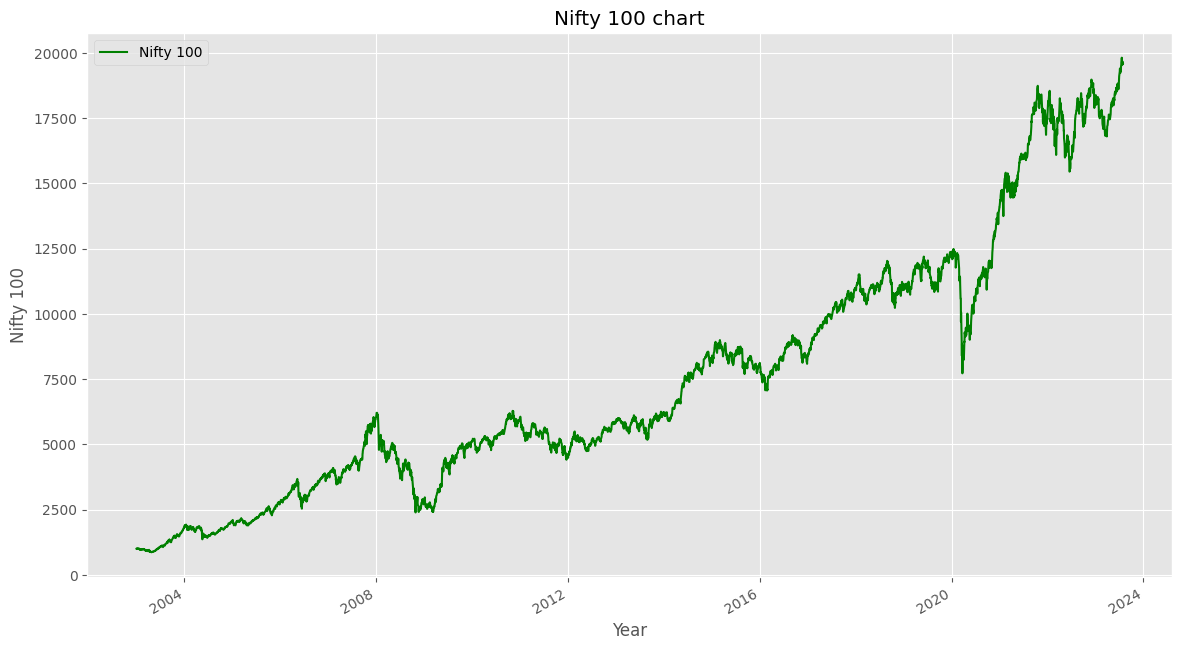

In [36]:

# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf=df_source[['Date','Nifty 100']]

# plotting the line chart with 'Date' as X axis
graphdf.set_index('Date').plot(kind='line',figsize=(14,8),color='green')
plt.title('Nifty 100 chart')
plt.xlabel('Year')
plt.ylabel('Nifty 100')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MH/pic01.png')
plt.show()

In [37]:
# declarations
daily_sip = 100
red_50 = 1 # when 50% crash occures, complete balace cash is invested (125/125)
red_40 = 0.5 # at 40% crash, half of balance cash is invested (125/250)
red_30 = 130/380 # at 30% crash, 130 out of 380 is invested
red_20 = 300/680
red_15 = 220/900
red_10 = 0.1 # at 10% crash, 10% of balance cash is invested (100/1000)

In [38]:
# creating a new data frame
df2=df_source.copy()

# counting number of rows
var_rows=len(df2.index)

# creating a new data frame to store peaks and flags for whether drawdown from this peak has happened
df_peak=pd.DataFrame(columns=['Date','Peak','D10','D15','D20','D30','D40','D50'])

# declaring a new variable to mark start of peak data frame
j=0

# adding columns and setting first row values
df2.loc[0,'Peak']=df2.loc[0,'Nifty 100'] # this col will have peak values of index till that date; first row peak = starting value
df2.loc[0,'Drawdown']=0.0 # this col will show drawdown from peak; first row peak = starting value
df2.loc[0,'Sip inv']=daily_sip # daily sip investment; first day's investment
df2.loc[0,'Sip net inv']=df2.loc[0,'Sip inv'] # col to store total sum of money invested
df2.loc[0,'Sip units']=df2.loc[0,'Sip inv']/df2.loc[0,'Nifty 100'] # units purchased on the first day
df2.loc[0,'Sip accumulated units']=df2.loc[0,'Sip units'] # col for accumulated units via sip; first day's value = first day's units purchased
df2.loc[0,'Sip market value']=df2.loc[0,'Sip accumulated units']*df2.loc[0,'Nifty 100'] # market value of sip
df2.loc[0,'Liquid inv']=daily_sip
df2.loc[0,'Liquid red units']=0
df2.loc[0,'Liquid add units']=df2.loc[0,'Liquid inv']/df2.loc[0,'Liquid NAV']
df2.loc[0,'Liquid net units']=df2.loc[0,'Liquid add units']
df2.loc[0,'Liquid value']=df2.loc[0,'Liquid net units']*df2.loc[0,'Liquid NAV']
df2.loc[0,'MH SIP inv']=0 # no investments done on the first day
df2.loc[0,'MH SIP units']=0
df2.loc[0,'MH SIP net units']=0
df2.loc[0,'MH SIP value']=0
df2.loc[0,'MH SIP + Liquid value']=df2.loc[0,'MH SIP value']+df2.loc[0,'Liquid value']

# setting first row values for peak data frame
df_peak.loc[0,'Date']=df2.loc[0,'Date']
df_peak.loc[0,'Peak']=df2.loc[0,'Peak']
df_peak.loc[0,'D10']=0 # 0 flags a 10% drawdown hasn't happened from this peak
df_peak.loc[0,'D15']=0
df_peak.loc[0,'D20']=0
df_peak.loc[0,'D30']=0
df_peak.loc[0,'D40']=0
df_peak.loc[0,'D50']=0

for i in range(1,var_rows):
  df2.loc[i,'Peak']=df2.loc[:i,'Nifty 100'].max() # for all days from the beginning till current date, max is stored in col. Peak
  df2.loc[i,'Drawdown']=(df2.loc[i,'Nifty 100']-df2.loc[i,'Peak'])*100/df2.loc[i,'Peak'] # drawdown is what percent current index value is down from the peak observed till that date
  df2.loc[i,'Sip inv']=daily_sip
  df2.loc[i,'Sip net inv']=df2.loc[i-1,'Sip net inv']+df2.loc[i,'Sip inv']
  df2.loc[i,'Sip units']=df2.loc[i,'Sip inv']/df2.loc[i,'Nifty 100']
  df2.loc[i,'Sip accumulated units']=df2.loc[i-1,'Sip accumulated units']+df2.loc[i,'Sip units']
  df2.loc[i,'Sip market value']=df2.loc[i,'Sip accumulated units']*df2.loc[i,'Nifty 100']
  df2.loc[i,'Liquid inv']=daily_sip
  df2.loc[i,'Liquid add units']=df2.loc[i,'Liquid inv']/df2.loc[i,'Liquid NAV']
  if (df2.loc[i,'Peak']>df2.loc[i-1,'Peak']): # a new peak is observed
    j=j+1
    df_peak.loc[j,'Peak']=df2.loc[i,'Peak'] # the new peak now stored in peak data frame
    df_peak.loc[j,'Date']=df2.loc[i,'Date']
    df_peak.loc[j,'D10']=0 # setting no drawdowns happened from this new peak
    df_peak.loc[j,'D15']=0
    df_peak.loc[j,'D20']=0
    df_peak.loc[j,'D30']=0
    df_peak.loc[j,'D40']=0
    df_peak.loc[j,'D50']=0
  if (df2.loc[i,'Drawdown']<=-50):
    if (df_peak.loc[j,'D50']==0): # if 50% drawdown is happening for the first time since the latest peak
      df_peak.loc[j,'D50']=1 # marking that 50% drawdown from new peak is addressed
      df_peak.loc[j,'D40']=1 # also marking all lesser drawdowns as addressed
      df_peak.loc[j,'D30']=1
      df_peak.loc[j,'D20']=1
      df_peak.loc[j,'D15']=1
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_50 # complete units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0 # 50% drawdown from this peak is not happening for the first time, so no redemption
  elif (df2.loc[i,'Drawdown']<=-40):
    if (df_peak.loc[j,'D40']==0):
      df_peak.loc[j,'D40']=1
      df_peak.loc[j,'D30']=1
      df_peak.loc[j,'D20']=1
      df_peak.loc[j,'D15']=1
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_40 # defined part of units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0
  elif (df2.loc[i,'Drawdown']<=-30):
    if (df_peak.loc[j,'D30']==0):
      df_peak.loc[j,'D30']=1
      df_peak.loc[j,'D20']=1
      df_peak.loc[j,'D15']=1
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_30 # defined part of units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0
  elif (df2.loc[i,'Drawdown']<=-20):
    if (df_peak.loc[j,'D20']==0):
      df_peak.loc[j,'D20']=1
      df_peak.loc[j,'D15']=1
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_20 # defined part of units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0
  elif (df2.loc[i,'Drawdown']<=-15):
    if (df_peak.loc[j,'D15']==0):
      df_peak.loc[j,'D15']=1
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_15 # defined part of units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0
  elif (df2.loc[i,'Drawdown']<=-10):
    if (df_peak.loc[j,'D10']==0):
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_10 # defined part of units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0
  else:
    df2.loc[i,'Liquid red units']=0 # no redemption from liquid
  df2.loc[i,'Liquid net units']=df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units']-df2.loc[i,'Liquid red units']
  df2.loc[i,'Liquid value']=df2.loc[i,'Liquid net units']*df2.loc[i,'Liquid NAV']
  df2.loc[i,'MH SIP inv']=df2.loc[i,'Liquid NAV']*df2.loc[i,'Liquid red units'] # what is redeemed from liquid is invested into MH SIP
  df2.loc[i,'MH SIP units']=df2.loc[i,'MH SIP inv']/df2.loc[i,'Nifty 100']
  df2.loc[i,'MH SIP net units']=df2.loc[i-1,'MH SIP net units']+df2.loc[i,'MH SIP units']
  df2.loc[i,'MH SIP value']=df2.loc[i,'MH SIP net units']*df2.loc[i,'Nifty 100']
  df2.loc[i,'MH SIP + Liquid value']=df2.loc[i,'MH SIP value']+df2.loc[i,'Liquid value']

In [39]:
df2.tail()

,Date,Liquid NAV,Nifty 100,Peak,Drawdown,Sip inv,Sip net inv,Sip units,Sip accumulated units,Sip market value,Liquid inv,Liquid red units,Liquid add units,Liquid net units,Liquid value,MH SIP inv,MH SIP units,MH SIP net units,MH SIP value,MH SIP + Liquid value
5063,2023-07-24,4478.1362,19540.45,19811.9,-1.370136,100.0,506400.0,0.005118,114.467512,2.236747e+06,100.0,0.0,0.022331,21.013996,94103.534500,0.0,0.0,96.676979,1.889112e+06,1.983215e+06
5064,2023-07-25,4478.9060,19566.90,19811.9,-1.236631,100.0,506500.0,0.005111,114.472623,2.239874e+06,100.0,0.0,0.022327,21.036323,94219.711074,0.0,0.0,96.676979,1.891669e+06,1.985888e+06
5065,2023-07-26,4479.7627,19662.00,19811.9,-0.756616,100.0,506600.0,0.005086,114.477709,2.250861e+06,100.0,0.0,0.022323,21.058645,94337.732892,0.0,0.0,96.676979,1.900863e+06,1.995200e+06
5066,2023-07-27,4480.5255,19566.70,19811.9,-1.237640,100.0,506700.0,0.005111,114.482820,2.240051e+06,100.0,0.0,0.022319,21.080964,94453.796426,0.0,0.0,96.676979,1.891649e+06,1.986103e+06
5067,2023-07-28,4481.2044,19580.65,19811.9,-1.167228,100.0,506800.0,0.005107,114.487927,2.241748e+06,100.0,0.0,0.022315,21.103279,94568.108293,0.0,0.0,96.676979,1.892998e+06,1.987566e+06


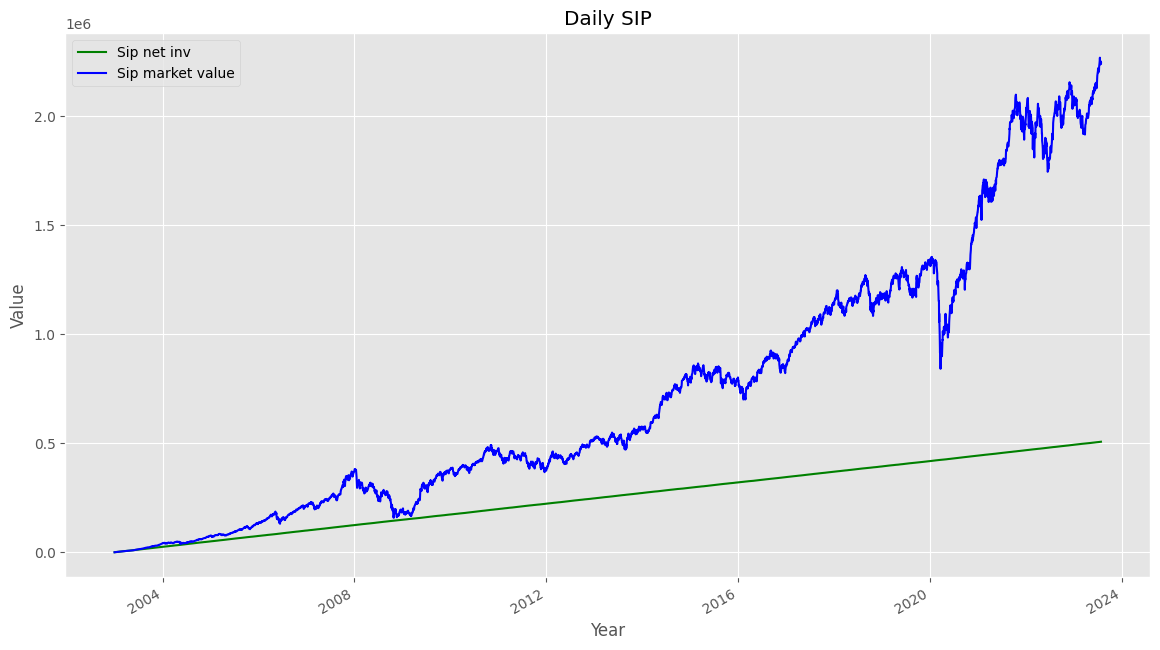

In [40]:
# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf=df2[['Date','Sip net inv','Sip market value']]

# plotting the line chart with 'Date' as X axis
graphdf.set_index('Date').plot(kind='line',figsize=(14,8),color=('green','blue'))
plt.title('Daily SIP')
plt.xlabel('Year')
plt.ylabel('Value')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MH/pic02.png')
plt.show()

In [41]:
df_peak.head()
# writing to excel
df_peak.to_excel('/content/drive/MyDrive/Colab Notebooks/MH/peaks.xlsx', sheet_name='peaks', index=False)

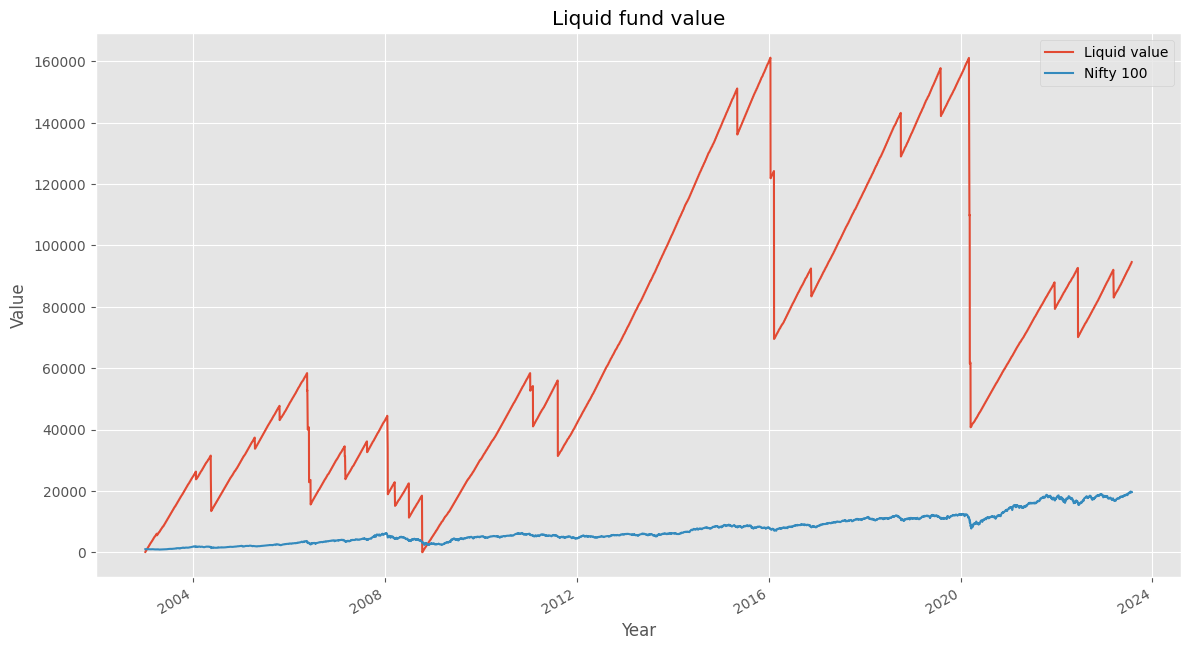

In [45]:
# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf=df2[['Date','Liquid value','Nifty 100']]

# plotting the line chart with 'Date' as X axis
graphdf.set_index('Date').plot(kind='line',figsize=(14,8))
plt.title('Liquid fund value')
plt.xlabel('Year')
plt.ylabel('Value')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MH/pic03.png')
plt.show()

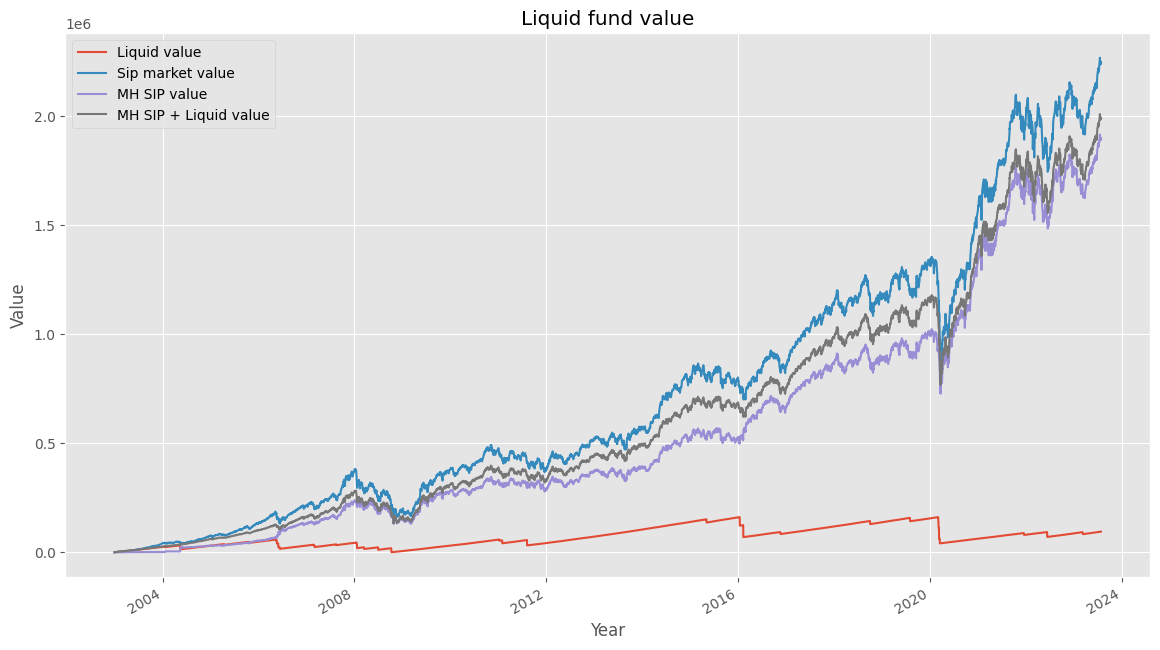

In [43]:
# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf=df2[['Date','Liquid value','Sip market value','MH SIP value','MH SIP + Liquid value']]

# plotting the line chart with 'Date' as X axis
graphdf.set_index('Date').plot(kind='line',figsize=(14,8))
plt.title('Liquid fund value')
plt.xlabel('Year')
plt.ylabel('Value')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MH/pic03.png')
plt.show()

In [44]:
# writing to excel
df2.to_excel('/content/drive/MyDrive/Colab Notebooks/MH/output.xlsx', sheet_name='data', index=False)

In [ ]:
"""
fig, ax1 = plt.subplots()
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y1-axis', color = color)
ax1.plot(x, dataset_1, color = color)
ax1.tick_params(axis ='y', labelcolor = color)

# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel('Y2-axis', color = color)
ax2.plot(x, dataset_2, color = color)
ax2.tick_params(axis ='y', labelcolor = color)

# Adding title
plt.title('Use different y-axes on the left and right of a Matplotlib plot', fontweight ="bold")

# Show plot
plt.show()

------------
# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf=df2[['Date','Liquid value','Sip market value','MH SIP value','MH SIP + Liquid value']]

# plotting the line chart with 'Date' as X axis
graphdf.set_index('Date').plot(kind='line',figsize=(14,8))
plt.title('Liquid fund value')
plt.xlabel('Year')
plt.ylabel('Value')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MH/pic03.png')
plt.show()
"""